## Setup and import some libraries

In [1]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip install torchrl
# pip install stable-baselines3[extra]
# !pip install torchvision
# !pip install gym==0.21
# !pip install --upgrade ipykernel
# !pip install matplotlib
# !pip install gym[atari,accept-rom-license]==0.21.0
# !pip install joblib
# !pip install tqdm

## Подключение библиотек

In [2]:
# hide imports
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torchvision
import numpy as np
import torchrl
import torch
import tqdm
from torchrl.envs import *
from torchrl.envs.libs.gym import *
from joblib import Parallel, delayed
import warnings
from multiprocessing import Pool
from agent import Agent
from constants import *
warnings.filterwarnings('ignore')

random_seed = 21

torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Версия gym

In [3]:
gym.version.VERSION

'0.21.0'

# Действие игры происходит в среде gym "Assault"

Давайте поменяем нашу среду для лучшего обучения.

Во-первых сделаем resize картинки до размера 64x64 (W = 64, H = 64).
Во-вторых переведем ее в черно-белое изображение.
В-третьих Добавим frameskip в 4 кадра.

Для этого воспользуемся классом TransformedEnv из torchrl.

In [4]:
#hide changing environment

_env = gym.make("ALE/Assault-v5").env

n_actions = _env.action_space.n # see more info in actions.txt

print("n_actions =", n_actions)

from torchrl.envs import *
from torchrl.envs.libs.gym import *


env = TransformedEnv(
    GymEnv("ALE/Assault-v5", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=W, h=H),
        GrayScale(in_keys=["pixels_trsf"]),
        FrameSkipTransform(4), 
        ExcludeTransform("pixels")
    ),
).to(device)

n_actions = 7


Как мы видим state это TensorDict, состоящий из нескольких параметров, в том числе done, pixels_trsf (Измененное изображение), terminated, truncated.

In [5]:
state = env.reset()

print(state)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([1, 84, 84]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


## Посмотрим, как выглядит изменная среда

torch.Size([1, 84, 84])


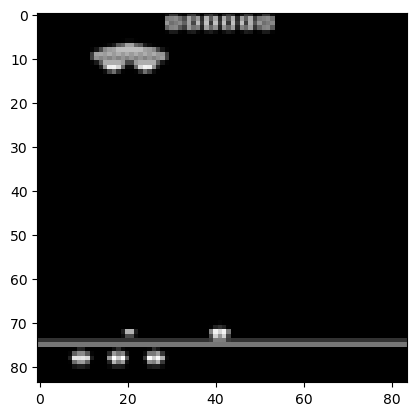

In [6]:
state = env.reset()

print(state['pixels_trsf'].shape)

plt.imshow(state['pixels_trsf'].cpu().permute(1, 2, 0), cmap="gray")

# Обучаем агента

### Для обучения агента я использую:
  * Нейронную сеть, состоящую из сверточных и полносвязных слоев. (Подробнее смотри файл network.py)
  * Реплей с приоритетами (TensorDictReplayBuffer) размера SIZE = 20000.
  * Optimizer - Adam
  * Для пересчета в Q-формуле использую target_network, которую обновляю каждые 30000 фреймов.
  
Для подробностей см. файл agent.py
Также есть возможность загрузки и сохранения агента.

In [7]:
# создаем агента
agent = Agent(num_channels=NUM_CHANNELS, width=W, height=H, n_actions=n_actions)

Size of layer after convolution layers 784
Size of layer after convolution layers 784


Добавим для наглядности графики

In [8]:
#hide plot
def plot(agent):
    clear_output(True)
    plt.figure(figsize=(20, 20))
    
    plt.subplot(221)
    plt.title('Rewards per frames')
    plt.xlabel("Frames")
    plt.ylabel("Reward")
    plt.plot(agent.frames, agent.reward_history, color='blue')
    
    plt.subplot(222)
    plt.title('Loss per frames')
    plt.xlabel("Frames")
    plt.ylabel("Loss")
    plt.plot(agent.frames, agent.loss_history, color='orange')
    
    plt.subplot(223)
    plt.title('Rewards per last 100 sessions')
    plt.xlabel("Sessions")
    plt.ylabel("Reward")
    plt.plot(agent.reward_history[-100:], color='blue')
    
    plt.subplot(224)
    plt.title('Loss per last 100 sessions')
    plt.xlabel("Sessions")
    plt.ylabel("Loss")
    plt.plot(agent.loss_history[-100:], color='orange')
    plt.show()

Играем сессию и записываем в агента опыт

In [9]:
# hide session
def play_session(agent, t_max=(int)(1e5), epsilon=0):
    env = TransformedEnv(
    GymEnv("ALE/Assault-v5", from_pixels=True),
        Compose(
            ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
            Resize(in_keys=["pixels_trsf"], w=W, h=H),
            GrayScale(in_keys=["pixels_trsf"]),
            FrameSkipTransform(4), 
            ExcludeTransform("pixels")
        ),
    ).to(device) # все как мы любим, изменненая среда.

    total_reward = 0
    state = env.reset()
    
    frames = 0

    for t in range(t_max):
        action = agent.select_action(state['pixels_trsf'], epsilon=epsilon)

        state['action'] = torch.zeros(n_actions)
        state['action'][action] = 1

        next_state = env.step(state)['next']

        next_state['done'] = next_state['done'] + next_state['terminated'] + next_state['truncated']
        next_state.pop('truncated', None)
        next_state.pop('terminated', None)

        state['next'] = next_state

        agent.record_experience(state)

        total_reward += next_state['reward']

        state = next_state
        
        frames += 1

        if next_state['done']:
            break
    
    return total_reward, frames

### Выбираем будем ли тренироваться и загружаться

In [10]:
loading = False
training = True
batch_size = 256

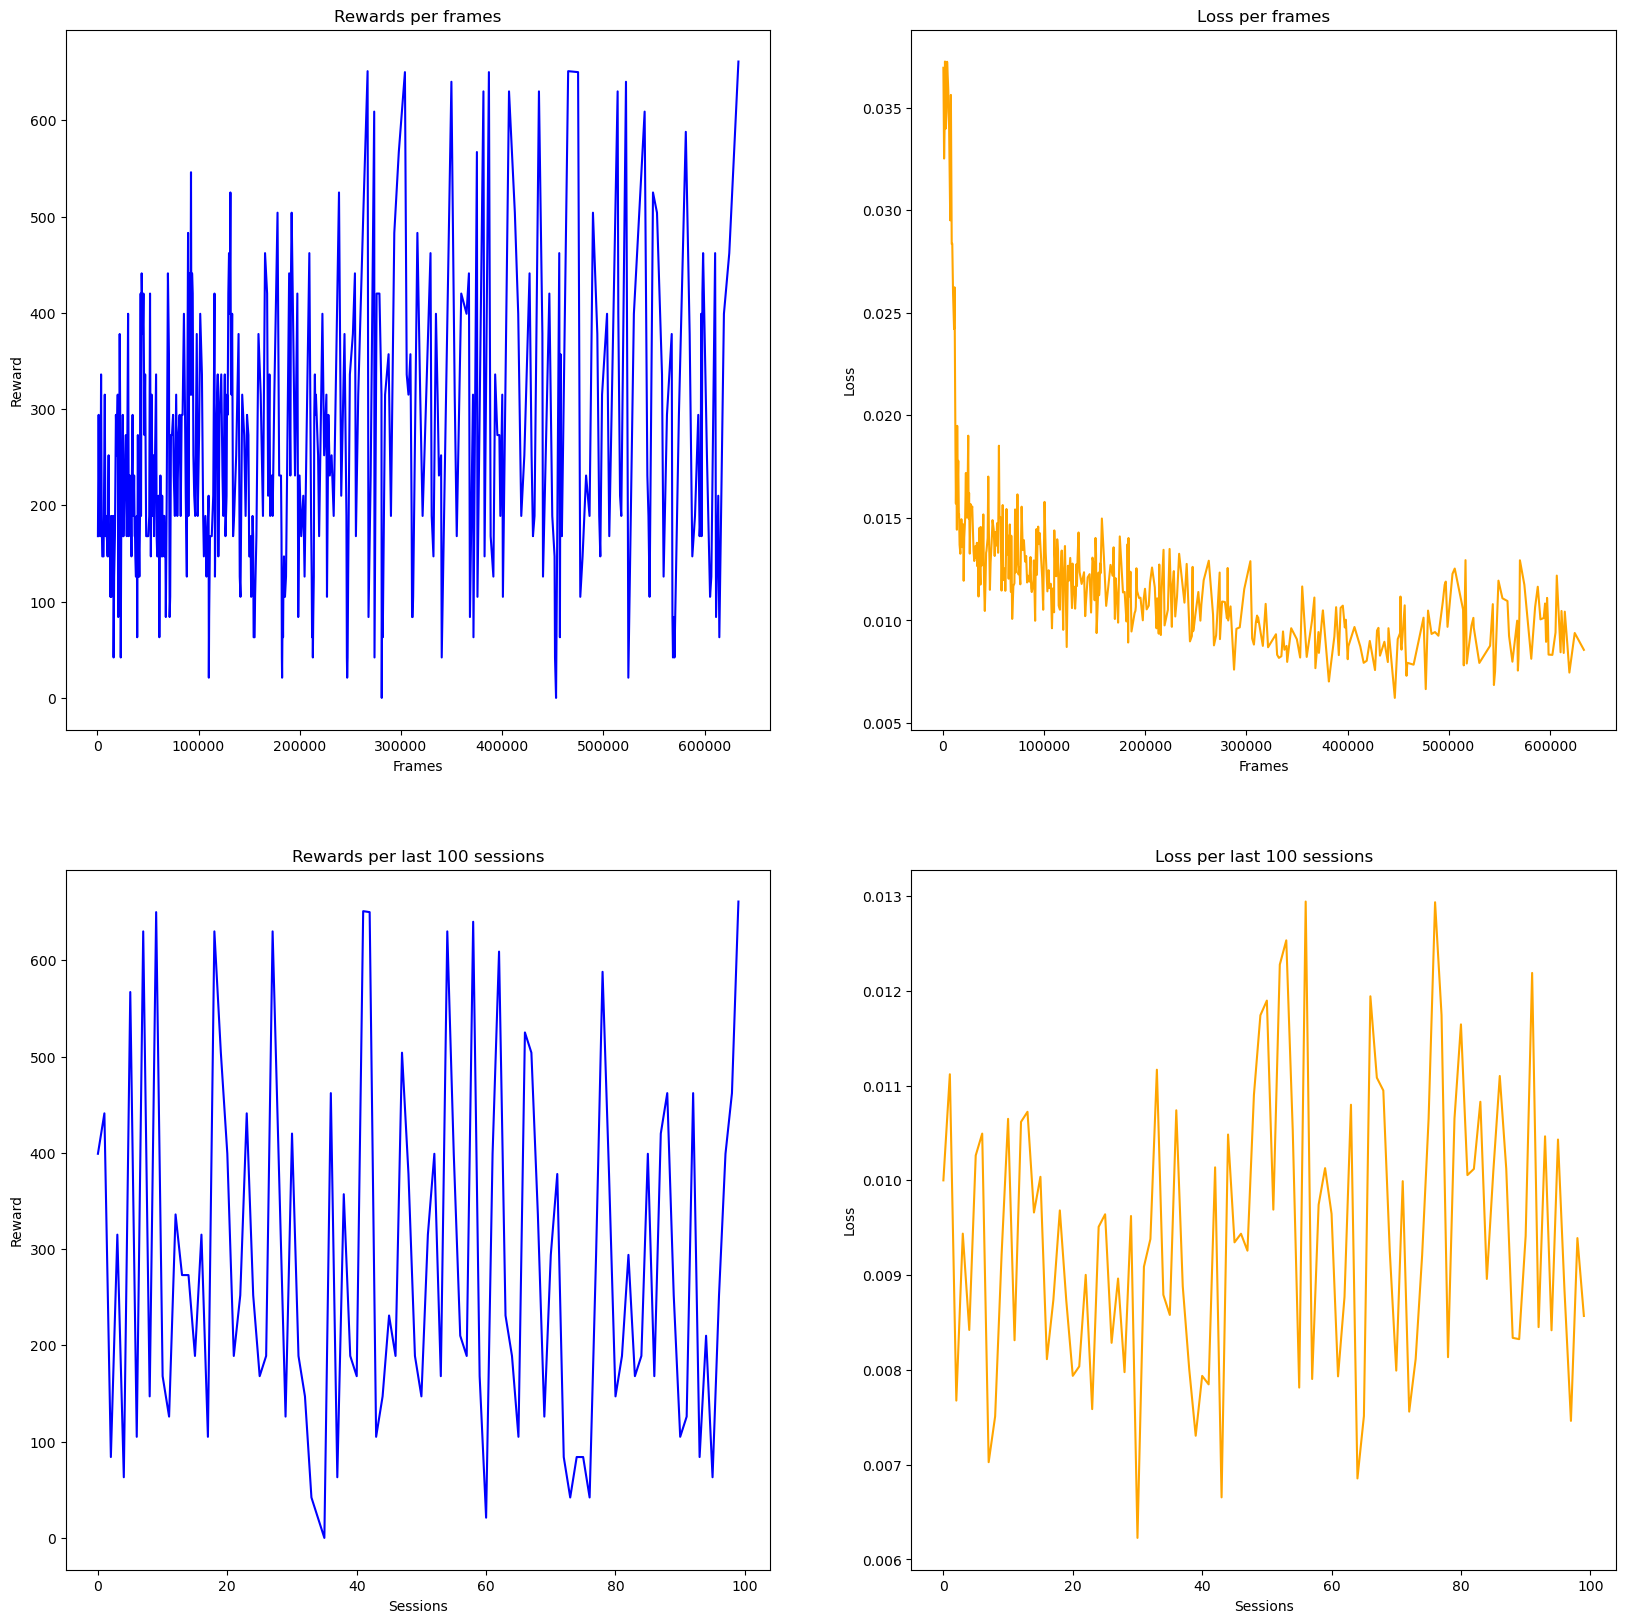

for frame =  633322 , epsilon =  0.13159584063434268


KeyboardInterrupt: 

In [11]:
if training:
    if loading:
        agent.load()

    agent.save()

    print("preparing (add random states to replay buffer)")
    if not loading:
        for i in tqdm.tqdm(range(20)):
            play_session(agent, epsilon=1)
    else:
        for i in tqdm.tqdm(range(20)):
            play_session(agent, epsilon=agent.epsilon)
    
    epoch = 0
    while True:
        rewards_for_session, count_frames = play_session(agent, t_max=(int)(agent.t_max), epsilon=agent.epsilon)
        rewards_for_session = np.asarray(torch.as_tensor(rewards_for_session).cpu())
        
        agent.epsilon *= 0.996

        loss = agent.train(batch_size)
        agent.loss_history.append(loss)
        agent.reward_history.append(np.mean(rewards_for_session))
        last_frames = 0
        if len(agent.frames) != 0:
            last_frames = agent.frames[-1]
        agent.frames.append(last_frames + count_frames)
        clear_output(True)
        
        plot(agent)
        print("for frame = ", last_frames + count_frames, ", epsilon = ", agent.epsilon)


        if agent.epsilon < 0.1:
            agent.epsilon = 0.12
        
        agent.t_max *= 1.01
        epoch += 1
        agent.t_max = min(agent.t_max, (int)(4e4))

        if epoch % 10 == 1:
            agent.save()
            print('saved successfully')     

In [ ]:
if not training:
    pass # lets see result!